In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.discrete.discrete_model import NegativeBinomial
%matplotlib inline

year           2001.031593
weekofyear       26.503434
total_cases      24.675137
dtype: float64


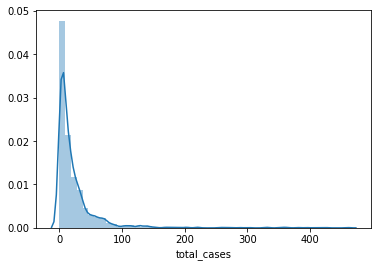

In [7]:
y = pd.read_csv("/media/vajira/0FD50F0F0FD50F0F/Sem7_Academic/Data Mining/dengAI/dengue_labels_train.csv")
sns.distplot(y.total_cases)
#plt.show()
print (y.mean())

> As is evident from the distribution of our y labels in the graph, we have a highly skewed distribution, that combined with the fact our labels are count variables, makes a very convincing case for using negative binomial regression!
You can read more about negative binomial regression [here](http://www.mathematica-journal.com/2013/06/negative-binomial-regression/)

### Modelling

#### importing the relevant packages and loading the data
In order to implement negative binomial regression, we use the go to statistical library for python, statsmodels!

In [7]:
import statsmodels.api as sm

from warnings import filterwarnings

filterwarnings('ignore')

from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

In [8]:
import numpy as np

from sklearn.model_selection import train_test_split
# from sklearn.feature_selection import RFE

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

from scipy import stats

from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

In [9]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

#### Pre Processing

In [10]:
def impute(X):
    
    # remove the colum that has ~20% null values, also ranks low on feature importance
    X.drop(['ndvi_ne'], axis=1, inplace=True)
    
    # Filling the rest using linear interpolation
    X.interpolate(inplace=True)

def remove_outliers(df):
    return df[(np.abs(stats.zscore(df)) < 5).all(axis=1)]

def mape(Y_test, Y_pred, epsilon = 1):
    return np.mean(np.abs((Y_test - Y_pred + epsilon) / (Y_test + epsilon))) * 100

def extract_month(s):
    return int(s[5:7])

def city_indices(X):
    # city boolean encoding
    return X.city == 'sj'

def pre_process(X, y, trees = False):
    """
    Extracts the month out of date and converts it to a one hot
    Standardizes the numerical features
    """
    
    #Extracting month from the date
    months = X.week_start_date.apply(extract_month)
    
    #Response coding
#     month = X.week_start_date.apply(extract_month)
#     temp = pd.DataFrame(y.total_cases)
#     temp['month'] = month
#     for name,group in temp.groupby(month):
#         month[group.index] = np.median(group.total_cases)
        
    # Removing the columns not required for classification
    X.drop(['city', 'year', 'weekofyear', 'week_start_date'], axis=1, inplace=True)

    # Standardizing the data
    if not trees:
        scaler = StandardScaler()
        X[X.columns] = scaler.fit_transform(X)

    # Month one hot features
    month_features = pd.get_dummies(months, prefix='m_')
    X = X.join(month_features)

    #Alternatively use response coding 
#     X = X.join(month)
    
    return X

def seperate_cities_data(X, is_sj):

    # Seperating the cities data
    X_sj = X.loc[is_sj]
    X_iq = X.loc[~is_sj]
    
    return X_sj, X_iq

def get_y_labels(X_sj, X_iq, y):    
    
    y = y.total_cases    
    y_sj = y.loc[X_sj.index]
    y_iq = y.loc[X_iq.index]
    
    return y_sj, y_iq

def split(X_sj, X_iq, y_sj, y_iq):

    # train and test split
    sj_split_data = train_test_split(X_sj, y_sj, shuffle = False)
    iq_split_data = train_test_split(X_iq, y_iq, shuffle = False)

    return sj_split_data, iq_split_data

def process(X, y = pd.Series(), train = True, trees = False, feature_selection = 0, time_shift = 0):
    
    is_sj = city_indices(X)
    if not trees:
        impute(X)
    X = pre_process(X, y, trees)
    
    if feature_selection:
        selector = SelectKBest(f_regression, k=feature_selection).fit(X,y.total_cases)
        X = X.loc[:,selector.get_support()]

    #X = remove_outliers(X)
    X_sj, X_iq = seperate_cities_data(X, is_sj)
    if y.empty:
        return X_sj, X_iq
    
    y_sj, y_iq = get_y_labels(X_sj, X_iq, y)
    if time_shift:
        y_sj = y_sj.shift(time_shift).dropna()
        y_iq = y_iq.shift(time_shift).dropna()
        X_sj = X_sj[:-time_shift]
        X_iq = X_iq[:-time_shift]
        
    if not train:
        return X_sj, X_iq, y_sj, y_iq
    
    return split(X_sj, X_iq, y_sj, y_iq)

In [12]:
X = pd.read_csv("/media/vajira/0FD50F0F0FD50F0F/Sem7_Academic/Data Mining/dengAI/dengue_features_train.csv")
data = process(X,y)

(X_sj_train, X_sj_test, Y_sj_train, Y_sj_test), (X_iq_train, X_iq_test, Y_iq_train, Y_iq_test) = data

#### Negative Binomial Regression

In [13]:
formula = ' + '.join([str(i) for i in list(X_sj_train.columns)])
formula = 'y ~ ' + formula

> We first examine results seperately on the two cities

#### The city of San Juan

In [19]:
train_sj = X_sj_train.copy()
train_sj['y'] = Y_sj_train
test_sj = X_sj_test.copy()

model = smf.glm(formula=formula,
                data=train_sj,
                family=sm.families.NegativeBinomial())
model = model.fit()

predictions_sj = model.predict(test_sj).astype(int)
#print (test_sj)

print ("cv error:", mean_absolute_error(predictions_sj, Y_sj_test))

pred_train_sj = model.predict(train_sj).astype(int)
print ("train error:", mean_absolute_error(pred_train_sj, Y_sj_train))

      ndvi_nw   ndvi_se   ndvi_sw  precipitation_amt_mm  \
702 -1.067275 -1.470795 -1.364071              1.168702   
703  0.298713 -0.886888 -0.924523              0.785077   
704 -0.606574 -1.866210 -1.522569              1.181994   
705 -0.944617 -1.016692 -0.802140              7.903910   
706 -1.386481  0.458440  0.077812             -0.676090   
707 -0.623109 -1.024504 -1.012159             -1.047340   
708 -2.357911 -0.561945 -1.128550              3.142056   
709 -1.510604  1.185482 -0.050560             -1.047340   
710 -1.403435 -0.610019 -0.647219             -1.002423   
711 -2.105896  0.279664 -0.304567             -1.024881   
712 -0.926197  0.157254  0.245382             -1.047340   
713 -1.048437  1.070689  1.053617             -0.220735   
714 -2.565760 -2.964682 -2.296999             -1.047340   
715 -1.974446  0.449142  0.939964             -1.047340   
716 -1.479626  0.674015  0.179997             -1.047340   
717 -0.876799  0.586467 -0.112693             -1.047340 

#### The city of iquitos

In [10]:
train_iq = X_iq_train.copy()
train_iq['y'] = Y_iq_train
test_iq = X_iq_test.copy()

model = smf.glm(formula=formula,
                data=train_iq,
                family=sm.families.NegativeBinomial())
results = model.fit()

predictions_iq = results.predict(test_iq).astype(int)
print ("cv error:", mean_absolute_error(predictions_iq, Y_iq_test))

pred_train_iq = results.predict(train_iq).astype(int)
print ("train error:", mean_absolute_error(pred_train_iq, Y_iq_train))

cv error: 8.069230769230769
train error: 5.441025641025641


#### single evaluation metric
Now the combined score for both the cities

In [11]:
pred = predictions_iq.append(predictions_sj)
true = Y_iq_test.append(Y_sj_test)
print ("cv error:", mean_absolute_error(pred, true))

train_pred = pred_train_iq.append(pred_train_sj)
train_true = Y_iq_train.append(Y_sj_train)
print ("train error:", mean_absolute_error(train_pred, train_true))

cv error: 17.412087912087912
train error: 18.32234432234432


#### Conclusion : 
 - Negative Binomial is by far the best model we have come across
 - We had high expectations from Time shifting the data but it actually decreases the performance
 
#### Next Steps :
At the next stage we shall dive into some more advanced statistical models